# Time-series Forecasting analysis

In [1]:
import numpy as np
import pandas as pd, datetime
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
from math import sqrt
import itertools
import statsmodels.api as sm
from statsmodels.tsa.arima_model import  ARIMA
from sklearn import model_selection
from sklearn.metrics import mean_squared_error, r2_score
from pandas import DataFrame
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

In [12]:
sales=pd.read_csv('train.csv')
output=pd.read_csv('sample-output.csv')

In [13]:
sales.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
0,1,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600
1,2,CA-2017-152156,08/11/2017,11/11/2017,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,Kentucky,42420.0,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400
2,3,CA-2017-138688,12/06/2017,16/06/2017,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,California,90036.0,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200
3,4,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775
4,5,US-2016-108966,11/10/2016,18/10/2016,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,Florida,33311.0,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680


In [14]:
sales['Order Date']=pd.to_datetime(sales['Order Date'])
last_date=sales['Order Date'].max()

In [15]:
sales.sort_values(by=['Order Date'],inplace=True)

In [16]:
sales.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales
540,541,CA-2015-140795,2015-01-02,03/02/2015,First Class,BD-11500,Bradley Drucker,Consumer,United States,Green Bay,Wisconsin,54302.0,Central,TEC-AC-10001432,Technology,Accessories,Enermax Aurora Lite Keyboard,468.900
5713,5714,US-2015-143707,2015-01-03,05/03/2015,Standard Class,HR-14770,Hallie Redmond,Home Office,United States,New York City,New York,10035.0,East,TEC-PH-10003655,Technology,Phones,Sannysis Cute Owl Design Soft Skin Case Cover ...,5.940
157,158,CA-2015-104269,2015-01-03,06/03/2015,Second Class,DB-13060,Dave Brooks,Consumer,United States,Seattle,Washington,98115.0,West,FUR-CH-10004063,Furniture,Chairs,Global Deluxe High-Back Manager's Chair,457.568
6548,6549,CA-2015-113880,2015-01-03,05/03/2015,Standard Class,VF-21715,Vicky Freymann,Home Office,United States,Elmhurst,Illinois,60126.0,Central,OFF-PA-10003036,Office Supplies,Paper,"Black Print Carbonless 8 1/2"" x 8 1/4"" Rapid M...",17.472
7949,7950,CA-2015-131009,2015-01-03,05/03/2015,Standard Class,SC-20380,Shahid Collister,Consumer,United States,El Paso,Texas,79907.0,Central,FUR-FU-10001095,Furniture,Furnishings,DAX Black Cherry Wood-Tone Poster Frame,63.552


In [17]:
totalweek=0
sales['week']=[None]*sales.shape[0]
for i in range(2015,2019):
    sales['week'].loc[sales['Order Date'].dt.year==i]=sales['Order Date'].dt.week + totalweek
    totalweek=totalweek + sales[sales['Order Date'].dt.year==2015]['Order Date'].dt.week.max()
    
sales['week_year']=sales['Order Date'].dt.week

In [18]:
sales.set_index('Order Date',inplace=True)

In [19]:
sales.head()

,Row ID,Order ID,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,State,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,week,week_year
Order Date,,,,,,,,,,,,,,,,,,,
2015-01-02,541,CA-2015-140795,03/02/2015,First Class,BD-11500,Bradley Drucker,Consumer,United States,Green Bay,Wisconsin,54302.0,Central,TEC-AC-10001432,Technology,Accessories,Enermax Aurora Lite Keyboard,468.900,1,1
2015-01-03,5714,US-2015-143707,05/03/2015,Standard Class,HR-14770,Hallie Redmond,Home Office,United States,New York City,New York,10035.0,East,TEC-PH-10003655,Technology,Phones,Sannysis Cute Owl Design Soft Skin Case Cover ...,5.940,1,1
2015-01-03,158,CA-2015-104269,06/03/2015,Second Class,DB-13060,Dave Brooks,Consumer,United States,Seattle,Washington,98115.0,West,FUR-CH-10004063,Furniture,Chairs,Global Deluxe High-Back Manager's Chair,457.568,1,1
2015-01-03,6549,CA-2015-113880,05/03/2015,Standard Class,VF-21715,Vicky Freymann,Home Office,United States,Elmhurst,Illinois,60126.0,Central,OFF-PA-10003036,Office Supplies,Paper,"Black Print Carbonless 8 1/2"" x 8 1/4"" Rapid M...",17.472,1,1
2015-01-03,7950,CA-2015-131009,05/03/2015,Standard Class,SC-20380,Shahid Collister,Consumer,United States,El Paso,Texas,79907.0,Central,FUR-FU-10001095,Furniture,Furnishings,DAX Black Cherry Wood-Tone Poster Frame,63.552,1,1


In [29]:
df=sales[['Sales']]
df.head()
df=df.groupby(pd.Grouper(freq='D')).sum()
train=df[:1400]
test=df[1400:] #Starts from 2018-11-02

In [23]:
# Define the p, d and q parameters to take any value between 0 and 3
p = d = q = range(0, 2)
# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA: ')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA: 
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [24]:
# Determing p,d,q combinations with AIC scores.
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df,
                                            order=param,
                                            seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:27179.601175852076
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:26862.580751612382
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:27406.459932486552
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:26235.204176535208
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:26822.22943744184
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:26396.580475536575
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:26738.12373509937
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:26191.8784233765
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:27004.738109552105
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:26738.808515510762
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:27378.240428864257
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:26169.598552552914
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:26752.970291448648
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:26454.667944035984
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:26796.09342800249
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:26168.62750029849
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:27447.40593396582
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:27224.647962426472

In [27]:
# Fitting the data to ARIMA model 
model_sarima = sm.tsa.statespace.SARIMAX(df,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results_sarima = model_sarima.fit()
print(results_sarima.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0678      0.023      2.913      0.004       0.022       0.113
ma.L1         -0.9967      0.006   -177.764      0.000      -1.008      -0.986
ar.S.L12      -0.0462      0.034     -1.375      0.169      -0.112       0.020
ma.S.L12      -1.0022      0.013    -77.842      0.000      -1.027      -0.977
sigma2      4.766e+06   2.64e-09   1.81e+15      0.000    4.77e+06    4.77e+06


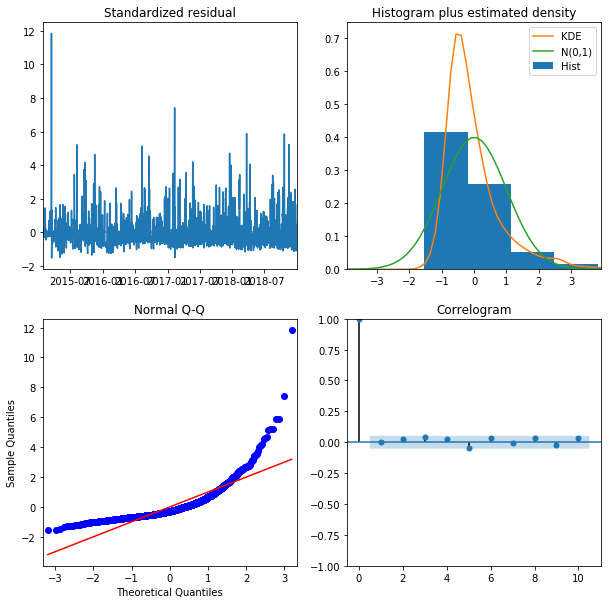

In [28]:
results_sarima.plot_diagnostics(figsize=(10, 10))
plt.show()

In [32]:
pred = results_sarima.get_prediction(start=pd.to_datetime('2018-11-02'), end=pd.to_datetime('2018-12-30'),dynamic = False)
# Get confidence intervals of forecasts
pred_ci = pred.conf_int()
train_arima_forecasted = pred.predicted_mean
train_arima_truth = test

rms_arima = sqrt(mean_squared_error(train_arima_truth, train_arima_forecasted))
print("Root Mean Squared Error: ", rms_arima)

Root Mean Squared Error:  2637.7985361274827


In [33]:
predictions=results_sarima.get_prediction(start=pd.to_datetime('2019-01-01'), end=pd.to_datetime('2019-01-07'),dynamic = False)

In [34]:
submit=pd.DataFrame(predictions.predicted_mean)
submit.rename({0:'Sales'},inplace=True)

In [35]:
submit.reset_index(inplace=True)
submit.rename(columns={'index':'Prediction Date',0:'Predicted Sales'},inplace=True)
submit['Predicted Sales']=submit['Predicted Sales'].round()
submit['Predicted Sales']=submit['Predicted Sales'].astype(int)

In [36]:
submit.head()

,Prediction Date,Predicted Sales
0,2019-01-01,2289
1,2019-01-02,2275
2,2019-01-03,1829
3,2019-01-04,1903
4,2019-01-05,2330


In [38]:
results_sarima.save('model.pkl')

In [ ]:
submit.to_csv('ouput.csv',index=False)